In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random as rd

### EDA

In [2]:
iris = pd.read_csv('IRIS.csv')

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
iris.species.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

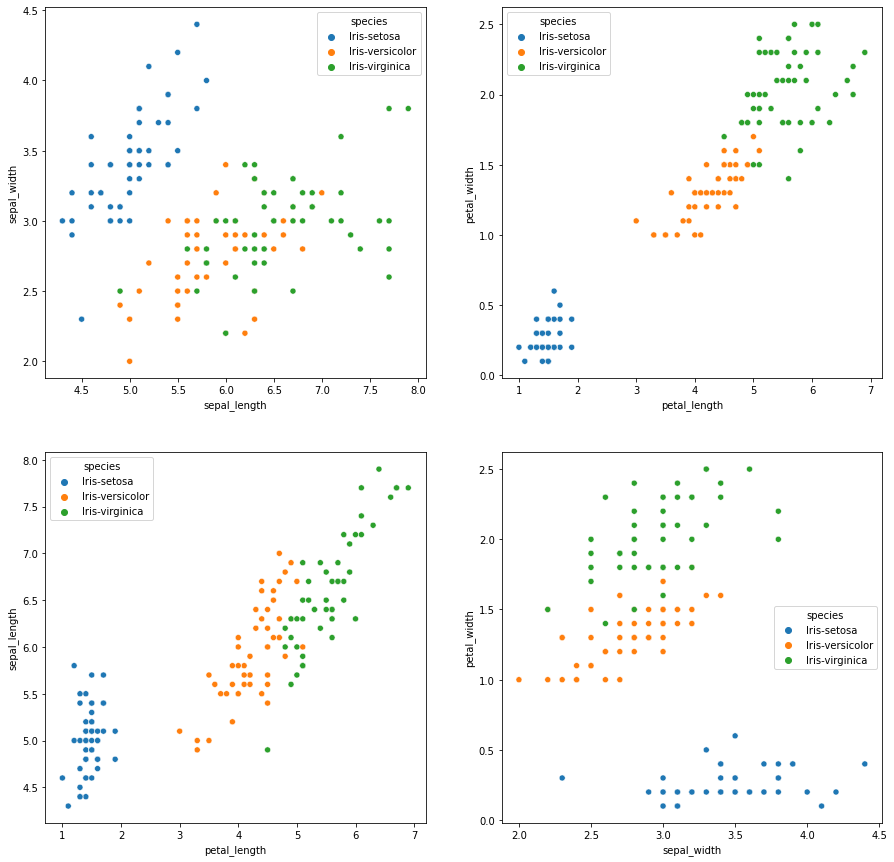

In [23]:
fig, axs = plt.subplots(figsize=(15,15),ncols=2, nrows=2)

sns.scatterplot(x='sepal_length', y='sepal_width', data=iris, hue=iris.species, ax=axs[0][0])
sns.scatterplot(x='petal_length', y='petal_width', data=iris, hue=iris.species, ax=axs[0][1])
sns.scatterplot(x='petal_length', y='sepal_length', data=iris, hue=iris.species, ax=axs[1][0])
sns.scatterplot(x='sepal_width', y='petal_width', data=iris, hue=iris.species, ax=axs[1][1])
plt.show()

## Now the neural network

### Ill write classes for the nodes and the NN, uisng relu activation for all layers, then applying softmax to the results

In [1940]:
class Neuron:
    # flag for input neurons
    is_input = False
    a = -1
    def __init__(self, prev_list):
        # get nodes leading into this node and their weights
        self.prev_list = prev_list
        self.prev_w = np.array([])
        self.b = 0
        for n in prev_list:
            self.prev_w = np.append(self.prev_w, rd.uniform(0,0.5))
        
        # check if neuron in input neuron
        if len(prev_list)==0:
            self.is_input = True
    
    # recursive forward propagation function
    def forward_prop(self, input_vals):
        if self.prev_list[0].is_input:
            self.a = (np.array(input_vals)*self.prev_w).sum()+self.b
            return self.a
        else:
            prev_layer = np.array([x.forward_prop(input_vals) for x in self.prev_list])
            self.a = (prev_layer*self.prev_w).sum()+self.b
            return self.a

class Neuron_relu(Neuron):
    # recursive forward propagation function with ReLu
    def forward_prop(self, input_vals):
        if self.prev_list[0].is_input:
            return self.relu(np.array(input_vals)*self.prev_w).sum()+self.b
        else:
            prev_layer = np.array([x.forward_prop(input_vals) for x in self.prev_list])
            return self.relu((prev_layer*self.prev_w).sum()+self.b)
    
    def relu(self, x):
        return (x>0)*x

In [1941]:
class NN:
    def __init__(self, n_layers, layer_size):
        # create the neural network
        self.n_layers = n_layers
        self.layers = []
        self.layer_size = layer_size
        for i in range(n_layers):
            self.layers.append([])
            for j in range(layer_size[i]):
                if i == 0:
                    prev = []
                else:
                    prev = self.layers[i-1]
                
                if i == n_layers-1:
                    self.layers[i].append(Neuron(prev))
                else:
                    self.layers[i].append(Neuron_relu(prev))
    
    # softmax function for the result layer
    def softmax(self, x):
        y = x-x.max()
        return np.exp(y)/sum(np.exp(y))
    
    # propagate forward and apply softmax to the result
    def predict(self, inputs):
        result = np.array([x.forward_prop(inputs) for x in self.layers[self.n_layers-1]])
        return np.round(self.softmax(result),3)
    
    # find the gradients for CE
    def grad_wb(self, inputs, ans):
        w = []
        b = []
        a = []
        for i in range(self.n_layers):
            if i==0:
                a.append(np.array(inputs))
            else:
                w.append(np.array([n.prev_w for n in self.layers[i]]))
                b.append(np.array([n.b for n in self.layers[i]]))
                if i<(self.n_layers-1):
                    a.append(np.array([self.layers[i][n].relu(self.layers[i][n].b+(self.layers[i][n].prev_w*a[i-1]).sum()) for n in range(self.layer_size[i])]))
                else:
                    #print([self.layers[i][n].prev_w for n in range(self.layer_size[i])],a[i-1])
                    a.append(np.array([self.layers[i][n].b+(self.layers[i][n].prev_w*a[i-1]).sum() for n in range(self.layer_size[i])]))
                    a[i] = self.softmax(a[i])
        
        delt = []
        for i in range(self.n_layers-1, 0, -1):
            if i==self.n_layers-1:
                d = []
                for j in range(len(ans)):
                    if ans[j]==0:
                        d.append(a[i][j])
                    else:
                        d.append(a[i][j]-1)
                delt.append(np.array(d))
            else:
                delt.append(np.array([ (delt[self.n_layers-1-i-1]*np.array([w[i][k][j] for k in range(self.layer_size[i+1])])*a[i][j]*(1-a[i][j])).sum() for j in range(self.layer_size[i])]))
        
        rdelt = [delt[len(delt)-i-1] for i in range(len(delt))]
        grad_w = [x.copy() for x in w]
        grad_b = [x.copy() for x in b]
        
        for i in range(self.n_layers-1, 0, -1):
            grad_b[i-1] = rdelt[i-1]
            for k in range(self.layer_size[i]):
                grad_w[i-1][k] = rdelt[i-1][k]*a[i-1]
        
        #for i in w:
        #    print(i)
        return [grad_w, grad_b, a, w]
    
    # use the gradients for training
    def train(self, inputs, outputs, lr=0.1, itterations=10):
        if not len(inputs)==len(outputs): 
            print("Amount of inputs and outputs need to match!")
            return 0
        
        step = itterations//10
        for it in range(itterations):
            if it>=10 and it%step==0:
                print("training is {p}% complete!".format(p = 10*it//step))
            curr_diff_w = -1
            curr_diff_b = -1
            
            for h in range(len(inputs)):
                curr_inp = inputs[h]
                curr_out = outputs[h]
                grads = self.grad_wb(curr_inp, curr_out)
                
                grad_w = grads[0]
                grad_b = grads[1]
                
                if h==0:
                    curr_diff_w = [x.copy() for x in grad_w]
                    for l in range(len(grad_w)):
                        curr_diff_w[l] *= 0
                    
                    curr_diff_b = [x.copy() for x in grad_b]
                    for l in range(len(grad_b)):
                        curr_diff_b[l] *= 0
                
                for l in range(len(grad_w)):
                    curr_diff_w[l] += grad_w[l]*lr
                    curr_diff_b[l] += grad_b[l]*lr
            
            for l in range(len(grad_w)):
                curr_diff_w[l] /= len(inputs)
                curr_diff_b[l] /= len(inputs)
            
                for i in range(self.layer_size[l+1]):
                    self.layers[l+1][i].b -= curr_diff_b[l][i]
                    self.layers[l+1][i].prev_w -= curr_diff_w[l][i]
        print("Done!")

In [1942]:
model = NN(4, [2,3,3,3])

In [1943]:
model.predict([0.1,0.2])

array([0.333, 0.335, 0.333])

In [1944]:
model.grad_wb(np.array([0.1,0.2]), [1,0,0])

[[array([[ 3.05603428e-06,  6.11206856e-06],
         [ 2.37041034e-06,  4.74082068e-06],
         [-1.04454223e-05, -2.08908447e-05]]),
  array([[-1.96307510e-04, -5.32607756e-05, -3.11339834e-04],
         [ 2.59647042e-04,  7.04456130e-05,  4.11795082e-04],
         [ 1.61482826e-05,  4.38123870e-06,  2.56108574e-05]]),
  array([[-0.03403217, -0.01758214, -0.01683487],
         [ 0.01706986,  0.00881885,  0.00844404],
         [ 0.0169623 ,  0.00876328,  0.00839083]])],
 [array([ 3.05603428e-05,  2.37041034e-05, -1.04454223e-04]),
  array([-0.00405016,  0.00535697,  0.00033317]),
  array([-0.66719024,  0.33464944,  0.3325408 ])],
 [array([0.1, 0.2]),
  array([0.04846903, 0.01315028, 0.07687093]),
  array([0.05100819, 0.02635251, 0.02523249]),
  array([0.33280976, 0.33464944, 0.3325408 ])],
 [array([[0.2936214 , 0.09553445],
         [0.07559699, 0.02795289],
         [0.4709458 , 0.14888173]]),
  array([[0.36839868, 0.03175857, 0.4258389 ],
         [0.39562211, 0.35781705, 0.032153

## Training and testing the model

In [1961]:
from sklearn.model_selection import train_test_split

In [1962]:
df = iris[['petal_length', 'petal_width', 'species']]
#df = df[df.species!='Iris-versicolor']
train, test = train_test_split(df, test_size=0.2)

In [1963]:
train

,petal_length,petal_width,species
67,4.1,1.0,Iris-versicolor
86,4.7,1.5,Iris-versicolor
128,5.6,2.1,Iris-virginica
109,6.1,2.5,Iris-virginica
112,5.5,2.1,Iris-virginica
...,...,...,...
45,1.4,0.3,Iris-setosa
4,1.4,0.2,Iris-setosa
89,4.0,1.3,Iris-versicolor
137,5.5,1.8,Iris-virginica


In [1964]:
train.species.value_counts()

Iris-setosa        42
Iris-versicolor    39
Iris-virginica     39
Name: species, dtype: int64

In [1965]:
train_inp = train.iloc[:,:2].values
train_inp[:6]

array([[4.1, 1. ],
       [4.7, 1.5],
       [5.6, 2.1],
       [6.1, 2.5],
       [5.5, 2.1],
       [4.5, 1.3]])

In [1966]:
rspec = {0:'Iris-setosa', 1:'Iris-versicolor', 2:'Iris-virginica'}

In [1967]:
spec = {'Iris-setosa':np.array([1,0,0]), 'Iris-versicolor':np.array([0,1,0]), 'Iris-virginica':np.array([0,0,1])}

train_out = [spec[i] for i in train.iloc[:,2].values]
train_out[:6]

[array([0, 1, 0]),
 array([0, 1, 0]),
 array([0, 0, 1]),
 array([0, 0, 1]),
 array([0, 0, 1]),
 array([0, 1, 0])]

In [1968]:
model = NN(5, [2,3,3,3,3])

In [1969]:
model.train(train_inp, train_out, lr=0.01, itterations=10000)

training is 10% complete!
training is 20% complete!
training is 30% complete!
training is 40% complete!
training is 50% complete!
training is 60% complete!
training is 70% complete!
training is 80% complete!
training is 90% complete!
Done!


In [1970]:
model.grad_wb(np.array([6,2.5]), [0,0,1])

[[array([[-0.00171983, -0.0007166 ],
         [-0.00173324, -0.00072219],
         [-0.00127487, -0.00053119]]),
  array([[-0.00098692, -0.000996  , -0.00107303],
         [-0.00164689, -0.00166204, -0.00179058],
         [-0.00118358, -0.00119447, -0.00128685]]),
  array([[-0.00635579, -0.0080156 , -0.00769992],
         [-0.003337  , -0.00420846, -0.00404271],
         [ 0.00224987,  0.00283742,  0.00272567]]),
  array([[ 0.00018208,  0.00018677,  0.00019513],
         [ 0.12211134,  0.12525967,  0.1308666 ],
         [-0.12229342, -0.12544645, -0.13106173]])],
 [array([-0.00028664, -0.00028887, -0.00021248]),
  array([-0.00130756, -0.00218196, -0.00156812]),
  array([-0.01150561, -0.00604082,  0.00407283]),
  array([ 0.00019201,  0.12877466, -0.12896667])],
 [array([6. , 2.5]),
  array([0.75477815, 0.76172157, 0.82063052]),
  array([0.55240816, 0.69666934, 0.66923213]),
  array([0.94825599, 0.97270436, 1.01624498]),
  array([1.92013506e-04, 1.28774660e-01, 8.71033326e-01])],
 [array

In [1971]:
model.predict([1.9,0.4])

array([0.872, 0.124, 0.004])

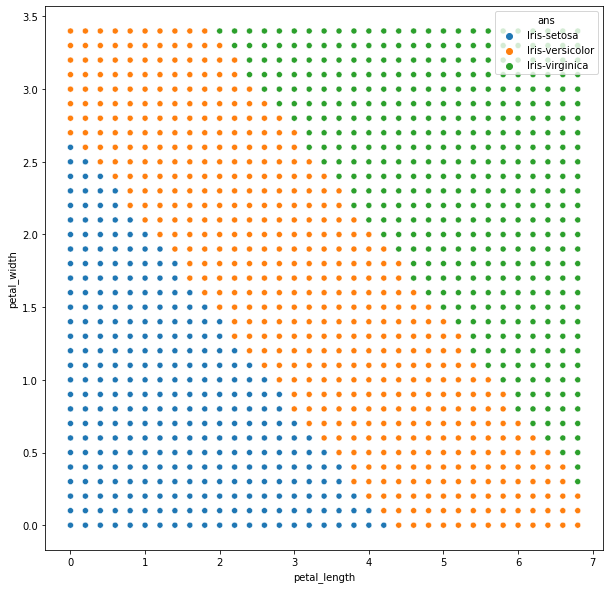

In [1972]:
X,Y = np.mgrid[0:7:0.2, 0:3.5:0.1]
xy = np.vstack((X.flatten(), Y.flatten()))

ans = []
for i in range(len(xy[0])):
    ans.append(rspec[np.argmax(model.predict([xy[0][i], xy[1][i]]))])

ans = pd.Series(ans)
x = pd.Series(xy[0])
y = pd.Series(xy[1])

visdf = pd.DataFrame({'ans':ans, 'petal_length':x, 'petal_width':y})

plt.figure(figsize=(10,10))
sns.scatterplot(x='petal_length', y='petal_width', data=visdf, hue=visdf.ans)
plt.show()

## Trained the model, now to see how it does on the test data

In [1973]:
test = test.reset_index().drop(columns='index')
test.head()

,petal_length,petal_width,species
0,1.7,0.2,Iris-setosa
1,6.9,2.3,Iris-virginica
2,4.4,1.4,Iris-versicolor
3,4.9,1.8,Iris-virginica
4,1.5,0.1,Iris-setosa


In [1974]:
a = []
for i in test.index:
    a.append(rspec[np.argmax(model.predict([test.loc[i, "petal_length"], test.loc[i, "petal_width"]]))])
    
test['predicted'] = pd.Series(a)

<AxesSubplot: xlabel='petal_length', ylabel='petal_width'>

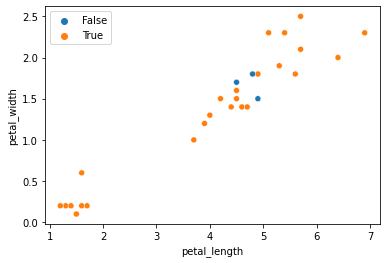

In [1975]:
sns.scatterplot(x='petal_length', y='petal_width', data=test, hue=test.species==test.predicted)

In [1976]:
print("Accuracy: {acc}".format(acc = (test.species==test.predicted).sum()/len(test)))

Accuracy: 0.9


## The Accuracy of our trained model is 90%